# 基于深度学习的机器视觉 - 路标识别

# 1.实验介绍
## 1.2实验背景
无人驾驶日益成熟，路标检测是其中一个基础任务，需要达到非常高的准确率来为后续的决策做支撑。

## 1.2 实验要求
a）建立深度神经网络模型，并尽可能将其调到最佳状态。   
b）绘制深度神经网络模型图、绘制并分析学习曲线。  
c）用准确率等指标对模型进行评估。

## 1.3 实验环境
可以使用基于 Python 的 OpenCV 库进行图像相关处理，使用 Numpy 库进行相关数值运算，使用 pytorch 等框架建立深度学习模型等。

## 1.4 注意事项
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）


## 1.5 参考资料
OpenCV：https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html  
Numpy：https://www.numpy.org/  
PyTorch：https://pytorch.org/

# 2.实验内容
## 2.1 介绍数据集
GTSRB 是一个多类图像识别数据集。

+ 43类交通标注
+ 超过50000张图片


+ 物品都是放在白板上在日光/室内光源下拍摄的，压缩后的尺寸为 512 * 384

导入数据集成功后路径：  
data_path = "./data"

## 2.2划分验证集

### 2.2.1划分之前的准备
因为挂载过来的数据比较凌乱，我们只需要到训练集数据，这里我们新建数据集路径./data 将原文件的train数据拷贝过来

In [ ]:
!mkdir data
!cp ./datasets/meowmeowmeowmeowmeow-gtsrb-german-traffic-sign-momodel/train ./data/train_images -r


### 2.2.2划分数据

每个图片名称前六位表示类别，中间6位数表示组数，一组有30张图片，这里将前三组划分为验证集

In [3]:
import os
def initialize_data(folder):
    # make validation_data by using images 00000*, 00001* and 00002* in each class
    train_folder = folder + '/train_images'
    val_folder = folder + '/val_images'
    if not os.path.isdir(val_folder):
        print(val_folder + ' not found, making a validation set')
        os.mkdir(val_folder)
        for dirs in os.listdir(train_folder):
            os.mkdir(val_folder + '/' + dirs)
            for f in os.listdir(train_folder + '/' + dirs):
                if f[6:11]==('00000') or f[6:11]==('00001') or f[6:11]==('00002'):
                    # move file to validation folder
                    os.rename(train_folder + '/' + dirs + '/' + f, val_folder + '/' + dirs + '/' + f)


In [4]:
data_path = "./data"
initialize_data(data_path)


现在随机展示其中的 6 张图片

数据集总数量: 39209


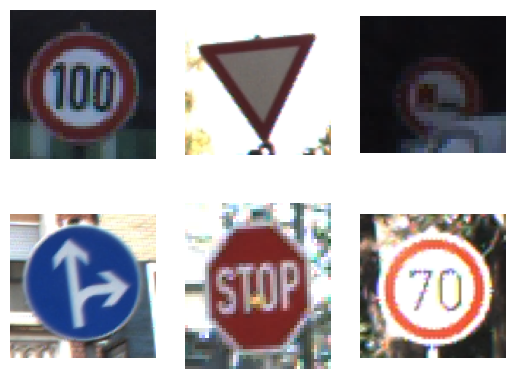

In [5]:
# 导入相关包
import glob, os

# 数据集路径


# 获取数据名称列表
img_list = glob.glob(os.path.join(data_path, '*/*/*.png'))

# 打印数据集总量
print("数据集总数量:", len(img_list))

import random,cv2
import numpy as np
import matplotlib.pyplot as plt

# 从数据名称列表 img_list 中随机选取 6 个。
for i, img_path in enumerate(random.sample(img_list, 6)):

    # 读取图片
    img = cv2.imread(img_path)

    # 将图片从 BGR 模式转为 RGB 模式
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 将窗口设置为 2 行 3 列 6个子图
    plt.subplot(2, 3, i + 1)

    # 展示图片
    plt.imshow(img)

    # 不显示坐标尺寸
    plt.axis('off')



## 2.3数据增强

In [6]:


import os

import torchvision.transforms as transforms

# data augmentation for training and test time
# Resize all images to 32 * 32 and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from the training set

data_transforms = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])

# Resize, normalize and jitter image brightness
data_jitter_brightness = transforms.Compose([
	transforms.Resize((32, 32)),
#     transforms.ColorJitter(brightness=-5),
    transforms.ColorJitter(brightness=5),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])


应用数据增强

In [7]:
def processing_data(data_path,batch_size,use_gpu):
    import torch
    from torchvision import datasets, transforms
    """
    数据处理
    :param data_path: 数据集路径
    :return:  train_loader,val_loader:处理后的训练集,验证集loader
    """
    #这里是把字典序转为按数字大小排列的序号 比如10这个文件夹的图片，原本通过datasets.ImageFolder获取到的label是2（按字典序排列 0，1，10，11，12，13...），现在转换为10
    def char_order2int_order(charoder):
        a = []
        for i in range(43):
            a.append(str(i))
        a.sort()
        kv={}
        for i in range (43):
            kv[i]=int(a[i])
        return kv[charoder]

    train_loader = torch.utils.data.DataLoader(
       torch.utils.data.ConcatDataset([
       datasets.ImageFolder(data_path + '/train_images',transform=data_transforms,target_transform=char_order2int_order),
       datasets.ImageFolder(data_path + '/train_images',transform=data_jitter_brightness,target_transform=char_order2int_order),

                                      ]),
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=use_gpu)

    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(data_path + '/val_images',transform=data_transforms,target_transform=char_order2int_order),
        batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=use_gpu)
    return train_loader,val_loader






### 对单张图片应用变换器

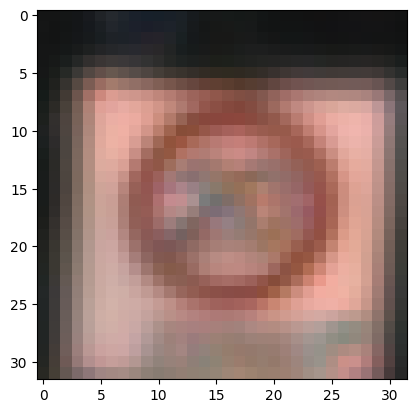

In [8]:
import torch
from torchvision import datasets, transforms
transforms = transforms.Compose([
transforms.Resize((32, 32)),
transforms.ToTensor(),
])
from PIL import Image
img=Image.open("./data/train_images/0/00000_00003_00000.png")
img=transforms(img)
plt.imshow(img.permute(1,2,0))


## 2.4网络架构


In [10]:
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43  # GTSRB as 43 classes


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(3, 100, kernel_size=5)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=3)
        self.conv3 = nn.Conv2d(150, 250, kernel_size=3)
        self.fc1 = nn.Linear(250 * 2 * 2, 350)
        self.fc2 = nn.Linear(350, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, 250 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


## 2.5训练网络

### 2.5.1训练函数和验证函数

In [11]:
from __future__ import print_function


import torch.optim as optim
import torchvision


import numpy as np
from tqdm import tqdm
def train(epoch):
    model.train()
    correct = 0
    training_loss = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = Variable(data), Variable(target)
        if use_gpu:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target,reduction="sum")
        loss.backward()
        optimizer.step()
        max_index = output.max(dim=1)[1]
        correct += (max_index == target).sum()
        training_loss += loss
    print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        training_loss / len(train_loader.dataset), correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return training_loss / len(train_loader.dataset), 100. * correct / len(train_loader.dataset)


def validation():
    from torch.autograd import Variable
    model.eval()
    validation_loss = 0
    correct = 0
    for batch_idx,(data, target) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
            if use_gpu:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction="sum").data.item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

#     scheduler.step(np.around(validation_loss, 2))
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss/len(val_loader.dataset), correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss/len(val_loader.dataset), 100. * correct / len(val_loader.dataset)


### 2.5.2训练超参

In [10]:
from __future__ import print_function
# import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time

#参数设置
class args:
    data = "./data"
    batch_size = 64
    epochs = 20
    lr = 0.0001
    seed = 1
    log_interval = 10

torch.manual_seed(args.seed)



if torch.cuda.is_available():
    use_gpu = True
    print("Using GPU")
else:
	use_gpu = False
	print("Using CPU")

train_loader,val_loader=processing_data(args.data,args.batch_size,use_gpu)
model = Net()

#优化器和学习率调整
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,factor=0.5,verbose=True)


res={"loss":[],"val_loss":[],"accuracy":[],"val_accuracy":[]}
#开始训练
start = time.time()
if use_gpu:
    model.cuda()

for epoch in range(1, args.epochs + 1):
    loss,acc=train(epoch)
    res["loss"].append(loss.cpu())
    res["accuracy"].append(acc.cpu())
    loss,acc=validation()
    res["val_loss"].append(loss)
    res["val_accuracy"].append(acc)
    model_file = 'results/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file,_use_new_zipfile_serialization=False)
    print('\nSaved model to ' + model_file )

print("模型训练总时长：",time.time()-start)
import pickle
with open("./results/res","wb") as f:
    pickle.dump(res,f)


Using GPU


100%|██████████| 1105/1105 [00:07<00:00, 147.89it/s]



Training set: Average loss: 1.6526, Accuracy: 38403/70678 (54%)



100%|██████████| 61/61 [00:00<00:00, 126.57it/s]



Validation set: Average loss: 1.1564, Accuracy: 2543/3870 (66%)


Saved model to results/model_1.pth


100%|██████████| 1105/1105 [00:07<00:00, 157.19it/s]



Training set: Average loss: 0.4980, Accuracy: 60919/70678 (86%)



100%|██████████| 61/61 [00:00<00:00, 152.56it/s]



Validation set: Average loss: 0.7100, Accuracy: 3097/3870 (80%)


Saved model to results/model_2.pth


100%|██████████| 1105/1105 [00:07<00:00, 149.23it/s]



Training set: Average loss: 0.3308, Accuracy: 64136/70678 (91%)



100%|██████████| 61/61 [00:00<00:00, 130.62it/s]



Validation set: Average loss: 0.6579, Accuracy: 3275/3870 (85%)


Saved model to results/model_3.pth


100%|██████████| 1105/1105 [00:07<00:00, 145.26it/s]



Training set: Average loss: 0.2679, Accuracy: 65262/70678 (92%)



100%|██████████| 61/61 [00:00<00:00, 115.11it/s]



Validation set: Average loss: 0.6005, Accuracy: 3390/3870 (88%)


Saved model to results/model_4.pth


100%|██████████| 1105/1105 [00:07<00:00, 157.73it/s]



Training set: Average loss: 0.2259, Accuracy: 66051/70678 (93%)



100%|██████████| 61/61 [00:00<00:00, 128.73it/s]



Validation set: Average loss: 0.5631, Accuracy: 3407/3870 (88%)


Saved model to results/model_5.pth


100%|██████████| 1105/1105 [00:07<00:00, 156.39it/s]



Training set: Average loss: 0.2050, Accuracy: 66419/70678 (94%)



100%|██████████| 61/61 [00:00<00:00, 116.47it/s]



Validation set: Average loss: 0.5462, Accuracy: 3435/3870 (89%)


Saved model to results/model_6.pth


100%|██████████| 1105/1105 [00:07<00:00, 155.50it/s]



Training set: Average loss: 0.1836, Accuracy: 66868/70678 (95%)



100%|██████████| 61/61 [00:00<00:00, 122.68it/s]



Validation set: Average loss: 0.7546, Accuracy: 3360/3870 (87%)


Saved model to results/model_7.pth


100%|██████████| 1105/1105 [00:07<00:00, 144.63it/s]



Training set: Average loss: 0.1693, Accuracy: 67121/70678 (95%)



100%|██████████| 61/61 [00:00<00:00, 136.02it/s]



Validation set: Average loss: 0.7494, Accuracy: 3396/3870 (88%)


Saved model to results/model_8.pth


100%|██████████| 1105/1105 [00:07<00:00, 150.47it/s]



Training set: Average loss: 0.1575, Accuracy: 67381/70678 (95%)



100%|██████████| 61/61 [00:00<00:00, 150.33it/s]



Validation set: Average loss: 0.5982, Accuracy: 3497/3870 (90%)


Saved model to results/model_9.pth


100%|██████████| 1105/1105 [00:06<00:00, 157.92it/s]



Training set: Average loss: 0.1517, Accuracy: 67490/70678 (95%)



100%|██████████| 61/61 [00:00<00:00, 146.87it/s]



Validation set: Average loss: 0.6865, Accuracy: 3475/3870 (90%)


Saved model to results/model_10.pth


100%|██████████| 1105/1105 [00:06<00:00, 161.12it/s]



Training set: Average loss: 0.1441, Accuracy: 67613/70678 (96%)



100%|██████████| 61/61 [00:00<00:00, 140.07it/s]



Validation set: Average loss: 0.6098, Accuracy: 3510/3870 (91%)


Saved model to results/model_11.pth


100%|██████████| 1105/1105 [00:06<00:00, 164.99it/s]



Training set: Average loss: 0.1331, Accuracy: 67874/70678 (96%)



100%|██████████| 61/61 [00:00<00:00, 131.77it/s]



Validation set: Average loss: 0.6787, Accuracy: 3487/3870 (90%)


Saved model to results/model_12.pth


100%|██████████| 1105/1105 [00:06<00:00, 161.50it/s]



Training set: Average loss: 0.1268, Accuracy: 67989/70678 (96%)



100%|██████████| 61/61 [00:00<00:00, 159.47it/s]



Validation set: Average loss: 0.8119, Accuracy: 3460/3870 (89%)


Saved model to results/model_13.pth


100%|██████████| 1105/1105 [00:06<00:00, 158.52it/s]



Training set: Average loss: 0.1217, Accuracy: 68061/70678 (96%)



100%|██████████| 61/61 [00:00<00:00, 144.50it/s]



Validation set: Average loss: 0.7023, Accuracy: 3476/3870 (90%)


Saved model to results/model_14.pth


100%|██████████| 1105/1105 [00:06<00:00, 162.28it/s]



Training set: Average loss: 0.1166, Accuracy: 68187/70678 (96%)



100%|██████████| 61/61 [00:00<00:00, 155.31it/s]



Validation set: Average loss: 0.7769, Accuracy: 3406/3870 (88%)


Saved model to results/model_15.pth


100%|██████████| 1105/1105 [00:06<00:00, 164.73it/s]



Training set: Average loss: 0.1130, Accuracy: 68260/70678 (97%)



100%|██████████| 61/61 [00:00<00:00, 139.02it/s]



Validation set: Average loss: 0.9847, Accuracy: 3381/3870 (87%)


Saved model to results/model_16.pth


100%|██████████| 1105/1105 [00:06<00:00, 159.45it/s]



Training set: Average loss: 0.1070, Accuracy: 68391/70678 (97%)



100%|██████████| 61/61 [00:00<00:00, 154.82it/s]



Validation set: Average loss: 0.7521, Accuracy: 3476/3870 (90%)


Saved model to results/model_17.pth


100%|██████████| 1105/1105 [00:07<00:00, 149.15it/s]



Training set: Average loss: 0.1066, Accuracy: 68430/70678 (97%)



100%|██████████| 61/61 [00:00<00:00, 134.03it/s]



Validation set: Average loss: 0.8478, Accuracy: 3455/3870 (89%)


Saved model to results/model_18.pth


100%|██████████| 1105/1105 [00:07<00:00, 150.66it/s]



Training set: Average loss: 0.1029, Accuracy: 68468/70678 (97%)



100%|██████████| 61/61 [00:00<00:00, 112.16it/s]



Validation set: Average loss: 0.8543, Accuracy: 3489/3870 (90%)


Saved model to results/model_19.pth


100%|██████████| 1105/1105 [00:06<00:00, 158.63it/s]



Training set: Average loss: 0.0987, Accuracy: 68568/70678 (97%)



100%|██████████| 61/61 [00:00<00:00, 144.41it/s]


Validation set: Average loss: 0.7765, Accuracy: 3524/3870 (91%)


Saved model to results/model_20.pth
模型训练总时长： 151.37449288368225


### 2.5.3模型训练过程图形化

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(res):
    """
    绘制模型的训练结果
    :param res: 模型的训练结果
    :return:
    """
    # 将张量转换为 NumPy 数组
    loss = res['loss'].detach().numpy() if isinstance(res['loss'], torch.Tensor) else res['loss']
    val_loss = res['val_loss'].detach().numpy() if isinstance(res['val_loss'], torch.Tensor) else res['val_loss']
    accuracy = res['accuracy'].detach().numpy() if isinstance(res['accuracy'], torch.Tensor) else res['accuracy']
    val_accuracy = res['val_accuracy'].detach().numpy() if isinstance(res['val_accuracy'], torch.Tensor) else res['val_accuracy']

    # 绘制模型训练过程的损失和平均损失
    plt.plot(loss, label='loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend(loc='upper right')
    plt.show()

    # 绘制模型训练过程中的准确率和平均准确率
    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy, label='val_accuracy')
    plt.legend()
    plt.show()

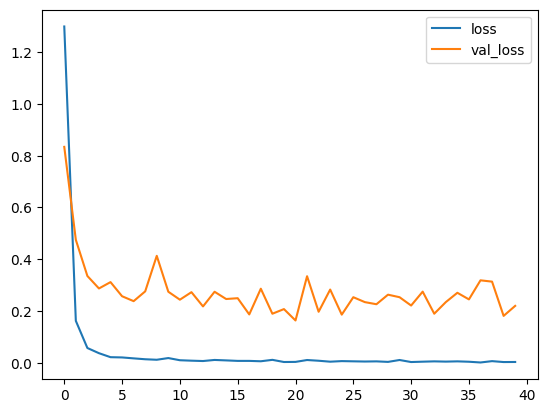

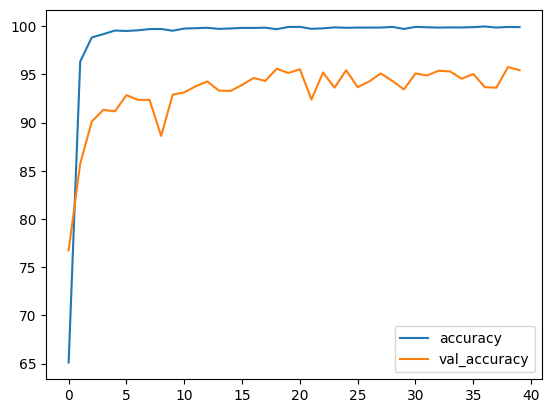

In [13]:
# 绘制模型训练过程曲线
#加载gpu训练的结果
import pickle
with open("./results/res", "rb") as f:
    res=pickle.load(f)
plot_training_history(res)


## 2.6加载模型和模型评估

In [ ]:
_,val_loader=processing_data(args.data,args.batch_size,use_gpu=False)
model_file = './results/model_1.pth'
model=Net()
model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))

# model.eval()
validation()


## 2.7作业
通过对以上步骤流程的了解，相信大家对深度学习有了深刻的认识，但是模型比较简单，准确率也不高，大家可以试着写自己的深度学习模型，并将其调到最佳状态。在训练模型等过程中如果需要**保存数据、模型**等请写到 **results** 文件夹。

### 2.7.1 训练深度学习模型

深度学习模型训练流程, 包含数据处理、创建模型、训练模型、模型保存、评价模型等。  
如果对训练出来的模型不满意, 你可以通过调整模型的参数等方法重新训练模型, 直至训练出你满意的模型。  
如果你对自己训练出来的模型非常满意, 则可以提交作业报告!  

注意：

1. 你可以在我们准好的接口中实现深度学习模型（若使用可以修改函数接口），也可以自己实现深度学习模型。
2. 写好代码后可以在 Py 文件中使用 GPU 进行模型训练

In [ ]:
def processing_data(data_path):
    """
    数据处理
    :param data_path: 数据集路径
    :return: train, test:处理后的训练集数据、测试集数据
    """
    # -------------------------- 实现数据处理部分代码 ----------------------------

    # ------------------------------------------------------------------------
    train_data, test_data = None, None
    return train_data, test_data


def model(train_data, test_data, save_model_path):
    """
    创建、训练和保存深度学习模型
    :param train_data: 训练集数据
    :param test_data: 测试集数据
    :param save_model_path: 保存模型的路径和名称
    :return:
    """
    # --------------------- 实现模型创建、训练和保存等部分的代码 ---------------------

    # 保存模型（请写好保存模型的路径及名称）
    # -------------------------------------------------------------------------

    return model


def evaluate_mode(test_data, save_model_path):
    """
    加载模型和评估模型
    可以实现，比如: 模型训练过程中的学习曲线，测试集数据的loss值、准确率及混淆矩阵等评价指标！
    主要步骤:
        1.加载模型(请填写你训练好的最佳模型),
        2.对自己训练的模型进行评估

    :param test_data: 测试集数据
    :param save_model_path: 加载模型的路径和名称,请填写你认为最好的模型
    :return:
    """
    # ----------------------- 实现模型加载和评估等部分的代码 -----------------------

    # ---------------------------------------------------------------------------


def main():
    """
    深度学习模型训练流程,包含数据处理、创建模型、训练模型、模型保存、评价模型等。
    如果对训练出来的模型不满意,你可以通过调整模型的参数等方法重新训练模型,直至训练出你满意的模型。
    如果你对自己训练出来的模型非常满意,则可以提交作业!
    :return:
    """
    data_path = None  # 数据集路径
    save_model_path = None  # 保存模型路径和名称

    # 获取数据
    train_data, test_data = processing_data(data_path)

    # 创建、训练和保存模型
    model(train_data, test_data, save_model_path)

    # 评估模型
    evaluate_mode(test_data, save_model_path)

    pred = output.data.max(1, keepdim=True)[1]

if __name__ == '__main__':
    main()


### 2.7.2 模型预测


注意：
1. 点击左侧栏`提交作业`后点击`生成文件`则只需勾选 `predict()` 函数的cell，即【**模型预测代码答题区域**】的 cell。
2. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
3. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
4. `predict()`函数的输入和输出请不要改动。
5. 作业测试时记得填写你的模型路径及名称, 如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请将模型保存在 **results** 文件夹下。

===========================================  **模型预测代码答题区域**  ===========================================  
在下方的代码块中编写 **模型预测** 部分的代码，请勿在别的位置作答

In [ ]:

# -------------------------- 请加载您最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 model_1.pth 模型，则 model_path = 'results/model_1.pth'



# ---------------------------------------------------------------------------

def predict(img):
    """
    加载模型和模型预测
    主要步骤:
        1.图片处理
        2.用加载的模型预测图片的类别
    :param img: PIL.Image 对象
    :return: int, 模型识别图片的类别
    """
    # -------------------------- 实现模型预测部分的代码 ---------------------------
    # 获取图片的类别
    # 把图片转换成为tensor



    # 获取输入图片的类别

    # -------------------------------------------------------------------------

    # 返回图片的类别
    return y_predict


In [ ]:

# 输入图片路径和名称
img_path = 'test_with_label_3.png'

# 打印该张图片的类别
print(predict(img_path))
